In [28]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import cuda

In [2]:
REBUILD_DATA = False

In [3]:
def make_training_data():
    img_dim = 50
    cats_dir = '../PetImages/Cat/'
    dogs_dir = '../PetImages/Dog/'
    labels = {cats_dir: 0, dogs_dir: 1}

    training_data = []
    cat_counter = 0
    dog_counter = 0
    for label in labels:
        for f in tqdm(os.listdir(label)):
            try:
                path = os.path.join(label, f)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_dim, img_dim))
                training_data.append([np.array(img), np.eye(2)[labels[label]]])

                if label == cats_dir:
                    cat_counter += 1
                elif label == dogs_dir:
                    dog_counter += 1
            except Exception as e:
                pass
                #print(str(e))

    # shuffle data in place
    np.random.shuffle(training_data)
    np.save('training_data.npy', training_data)
    print('Cats:', cat_counter)
    print('Dogs:', dog_counter)

In [4]:
if REBUILD_DATA:
    make_training_data()

In [5]:
training_data = np.load('training_data.npy', allow_pickle = True)

In [6]:
training_data[0]

array([array([[ 17, 135, 138, ..., 184, 186, 188],
              [ 17, 123, 149, ..., 184, 186, 188],
              [ 17, 107, 145, ..., 183, 187, 188],
              ...,
              [227, 229, 226, ..., 234, 232, 235],
              [226, 227, 227, ..., 233, 225, 230],
              [230, 229, 229, ..., 226, 216, 172]], dtype=uint8),
       array([1., 0.])], dtype=object)

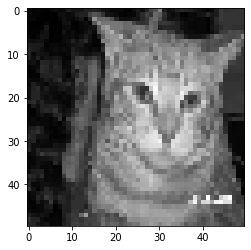

In [7]:
plt.imshow(training_data[1][0], cmap = 'gray')
plt.show()

In [59]:
cuda.is_available()

True

In [60]:
if cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [9]:
def conv_output_size(input_size, kernel_size, stride, padding):
    return int((input_size - kernel_size + 2*padding)/stride + 1)

In [40]:
class DogNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) # (in, out, kernel, stride, padding)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        #print(x[0].shape)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]

        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.softmax(x, dim = 1)

In [71]:
net = DogNet()
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [72]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X / 255. # scale to 0-1
y = torch.Tensor([i[1] for i in training_data])

In [73]:
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [74]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(train_y))
print(len(test_X), len(test_y))

22452 22452
2494 2494


In [75]:
BATCH_SIZE = 128
EPOCHS = 10

for epoch in range(EPOCHS):
    tic = time.time()
    for i in trange(0, len(train_X), BATCH_SIZE):
        start_ind = i
        end_ind = i + BATCH_SIZE

        batch_X = train_X[start_ind:end_ind].view(-1, 1, 50, 50)
        batch_y = train_y[start_ind:end_ind]

        batch_X = batch_X.to(device)

        net.zero_grad() # optimizer.zero_grad()
        outputs = net(batch_X)
        outputs = outputs.to('cpu')
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
    toc = time.time()
    #print(toc-tic)

100%|███████████████████████████████████████████████████████████████████████████████| 176/176 [00:01<00:00, 126.05it/s]


In [76]:
loss

tensor(0.0654, grad_fn=<MseLossBackward>)

In [86]:
correct = 0
total = 0

with torch.no_grad():
    for i in trange(len(test_X)):
        real_class = torch.argmax(test_y[i])
        test_sample = test_X[i].view(-1,1,50,50)
        test_sample = test_sample.to(device)
        net_out = net(test_sample)[0]
        net_out = net_out.to('cpu')
        #net_out = net_out.detach().numpy()
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total +=1
print('Accuracy:', round(correct/total,3))

100%|████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:01<00:00, 1586.59it/s]

Accuracy: 0.767
